**1. Clone the Git Repo**  

In [ ]:
!git clone https://github.com/hunter3789/Deep-Learning-QPF.git

Cloning into 'Deep_Learning_QPF'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 149 (delta 18), reused 0 (delta 0), pack-reused 111 (from 1)
Receiving objects: 100% (149/149), 184.33 MiB | 7.97 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (37/37), done.


In [ ]:
%cd Deep-Learning-QPF

/content/Deep_Learning_QPF


**2. Load the model and files**  

In [ ]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/Deep-Learning-QPF')
from work.models_gan import load_model
from work.load_dataset_gan import load_data

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("CUDA not available, using CPU")
    device = torch.device("cpu")

# load model
model_gen = load_model('regressor', with_weights=True)

# load files
mean_std_file = './work/files/trainset_ssrd_agg_mean_std.npz'
mean, std = np.load(mean_std_file)['mean'], np.load(mean_std_file)['std']

label_mean_std_file = './work/files/trainset_label_agg_mean_std.npz'
label_mean, label_std = np.load(label_mean_std_file)['mean'], np.load(label_mean_std_file)['std']

topo_file = './work/files/topo_norm.npz'
topo = np.load(topo_file)['topo']

# load sample data
inference_data = load_data(mean=mean, std=std, topo=topo, label_mean=label_mean, label_std=label_std, dataset_path="./sample", shuffle=True, batch_size=1, num_workers=0, transform_pipeline="default")

CUDA not available, using CPU
CUDA not available, using CPU


**3. Inference and plot the results**  

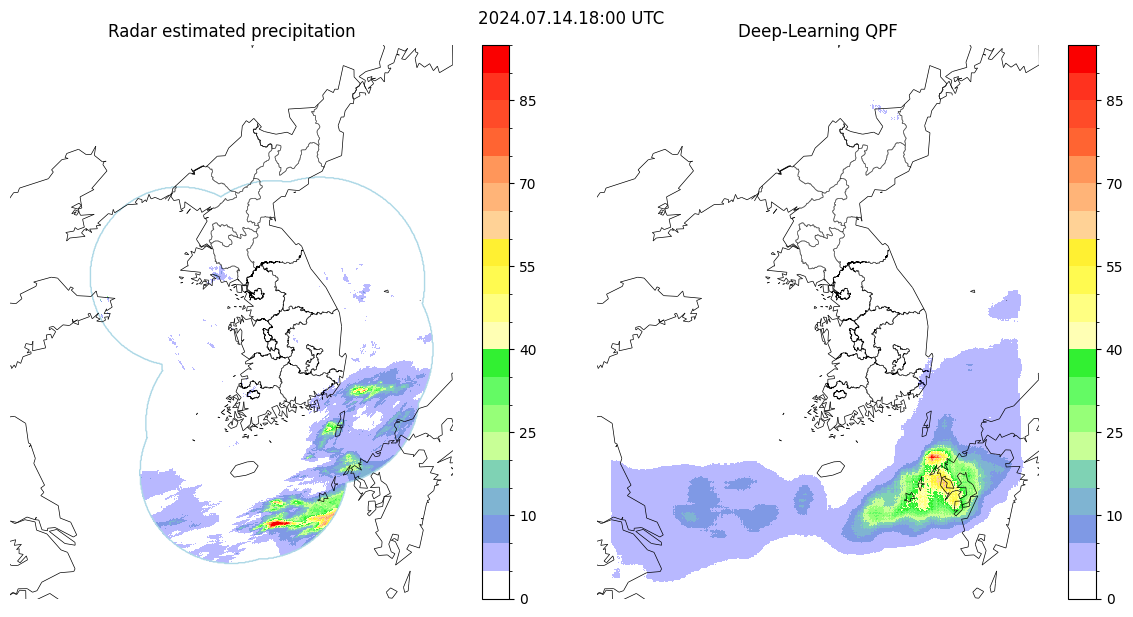

In [ ]:
from work.plot_inference import get_linecollection, visualize, parse_case

# inference
model_gen.eval()

with torch.inference_mode():
    for data in inference_data:
        img, label, mask = data['image'], data['label'], data['mask']
        img, label, mask = img.to(device), label.to(device), mask.to(device)
        label = label.type(torch.float32)

        case = data['case'].squeeze().detach().cpu().numpy()
        pred = model_gen(img).squeeze()

        # plot
        visualize(label_std, label_mean, parse_case(str(case)), pred, label, mask)
        break